# Modele analizy danych

Tomasz Rodak

---

### Zadanie 10.1

Celem tego zadania jest wizualizacja i ocena jakości klasyfikacji na sztucznie wygenerowanych danych dla modeli:
1. regresji logistycznej,
2. LDA,
3. QDA,
4. KNN,
5. Naiwnego Bayesa.

Podany niżej kod generuje dane z rozkładu normalnego (pod warunkiem klasy) o średnich i macierzach kowariancji kontrolowanych przez użytkownika.
1. Wykorzystaj go do wygenerowania przykładowych danych.
2. Uzyskane dane podziel na zbiór treningowy i testowy.
3. Przeprowadź klasyfikację na zbiorze treningowym i ocen jakość klasyfikacji na zbiorze testowym.
4. W modelach generatywnych sprawdź jak wyglądają wyznaczone przez model średnie i macierze kowariancji w każdej z klas. Czy są one zbliżone do wartości, z których generowano dane? W każdym przypadku zastanów się, jakie są założenia modelu i czy są one spełnione w danych.
5. Przedstaw graficznie granice decyzyjne dla każdego z modeli. Przeprowadź różne eksperymenty, zmieniając parametry generacji danych, takie jak liczba klas, liczba obserwacji w klasie, wartości średnich i macierzy kowariancji.

Do wyznaczania granic decyzyjnych możesz wykorzystać `sklearn.inspection.DecisionBoundariesDisplay`.

---

In [117]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

# Upgrade scikit-learn to ensure 'covariances_' attribute is available for QDA
!pip install --upgrade scikit-learn

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ortho_group

def make_random_psd_matrix(eigenvalues, random_rotation=False, seed=None):
    p = len(eigenvalues)
    if random_rotation:
        np.random.seed(seed)
        Q = ortho_group.rvs(p)
    else:
        Q = np.eye(p)
    S = np.diag(eigenvalues)
    return Q @ np.sqrt(S) @ Q.T

def multivariate_normal(n, mu, psd):
    p = len(mu)
    X = np.random.normal(0, 1, (n, p))
    return X @ psd.T + mu

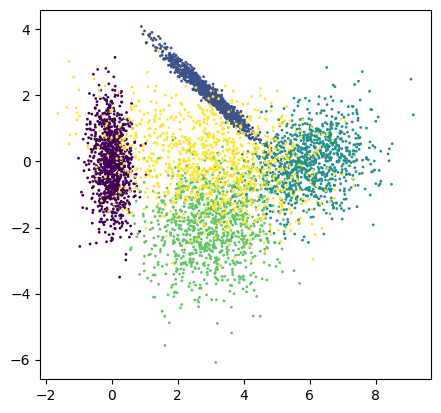

In [119]:
n = [1000, 1000, 1000, 1000, 1000] # number of samples per class
lbd = [[1, .1], [0.01, 1], [1, .5], [1, 1], [3, 1]] # eigenvalues of the covariance matrix in each class
mu = [[0, 0], [3, 2], [6, 0], [3, -2],[3, 0]] # mean of the distribution in each class

X, y = np.empty((0, 2)), np.empty(0)
for n_, lbd_, mu_ in zip(n, lbd, mu):
    psd = make_random_psd_matrix(lbd_, random_rotation=True, seed=None)
    X_ = multivariate_normal(n_, mu_, psd)
    X = np.vstack([X, X_])
    y = np.hstack([y, np.full(n_, len(y))])

fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=1, alpha=1)
ax.set_aspect('equal');

In [120]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [121]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3500, 2), (1500, 2), (3500,), (1500,))

KNN - nie ma zalozen, nieparametryczny, "zawsze pasuje"

In [122]:
n_neighbours = 50
knn = KNeighborsClassifier(n_neighbours)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [123]:
y_knn_pred = knn.predict(x_test)

In [124]:
accuracy_score(y_test, y_knn_pred)

0.8573333333333333

In [125]:
confusion_matrix(y_test, y_knn_pred)

array([[301,   0,   0,   1,   0],
       [  0, 306,   5,   0,   1],
       [  0,   0, 276,   7,   9],
       [  1,   1,   6, 259,  33],
       [ 23,  23,  49,  55, 144]])

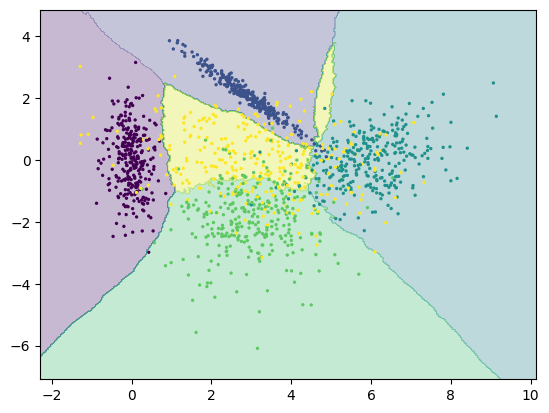

In [126]:
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(knn, x_test, grid_resolution=400, ax=ax, alpha=.3)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='viridis', s=2, alpha=1)


LDA - zaklada ze macierze kowariancji sa takie same, nie pasuje

In [127]:
lda = LDA(store_covariance=True)
lda.fit(x_train, y_train)
y_lda_pred = lda.predict(x_test)

In [128]:
accuracy_score(y_test, y_lda_pred)

0.8313333333333334

In [129]:
confusion_matrix(y_test, y_knn_pred)

array([[301,   0,   0,   1,   0],
       [  0, 306,   5,   0,   1],
       [  0,   0, 276,   7,   9],
       [  1,   1,   6, 259,  33],
       [ 23,  23,  49,  55, 144]])

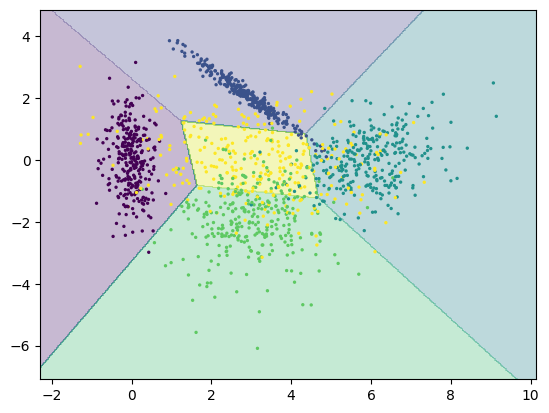

In [130]:
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(lda, x_test, grid_resolution=400, ax=ax, alpha=.3)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='viridis', s=2, alpha=1)


In [131]:
lda.covariance_

array([[ 0.99902101, -0.13889716],
       [-0.13889716,  0.83446942]])

In [132]:
lda.means_, mu

(array([[ 2.58739928e-03, -7.03776408e-02],
        [ 2.97581674e+00,  2.03193032e+00],
        [ 5.99984643e+00, -4.26438796e-02],
        [ 2.99834801e+00, -1.97646677e+00],
        [ 2.99165680e+00, -3.43119503e-03]]),
 [[0, 0], [3, 2], [6, 0], [3, -2], [3, 0]])

In [133]:
label = 0
A = x_test[y_test == label] - x_test[y_test == label].mean(axis=0)
(A.T @ A) / len(A)

array([[ 0.08944263, -0.04162706],
       [-0.04162706,  1.01118117]])

LogReg - nie ma zalozen, ale pochodzi od lda, niezbyt dobra

In [134]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_lr_pred = lr.predict(x_test)

In [135]:
accuracy_score(y_test, y_lr_pred)

0.8446666666666667

In [136]:
confusion_matrix(y_test, y_lr_pred)

array([[299,   1,   0,   1,   1],
       [  0, 300,   4,   0,   8],
       [  0,   5, 259,   9,  19],
       [  1,   0,   4, 242,  53],
       [ 17,  21,  45,  44, 167]])

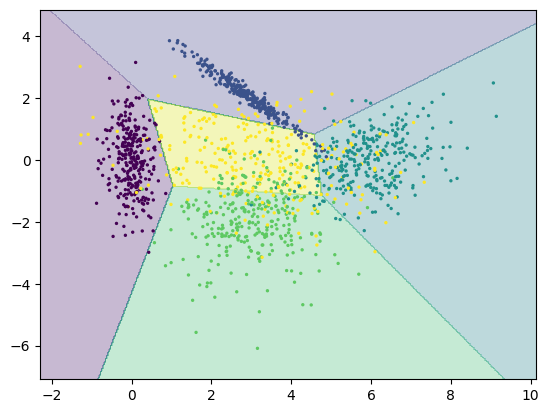

In [137]:
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(lr, x_test, grid_resolution=400, ax=ax, alpha=.3)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='viridis', s=2, alpha=1)

QDA - wlasciwe dla wprowaconych danych

In [138]:
qda = QDA(store_covariance=True)
qda.fit(x_train, y_train)
y_qda_pred = qda.predict(x_test)

In [139]:
accuracy_score(y_test, y_qda_pred)

0.8726666666666667

In [140]:
confusion_matrix(y_test, y_qda_pred)

array([[299,   0,   0,   1,   2],
       [  0, 305,   3,   0,   4],
       [  0,   2, 274,   5,  11],
       [  1,   0,   6, 253,  40],
       [ 12,   7,  47,  50, 178]])

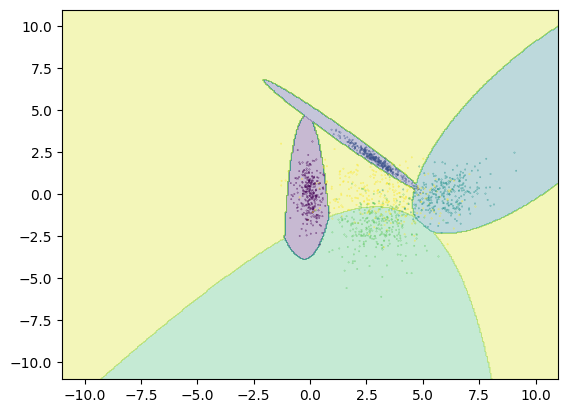

In [141]:
fig, ax = plt.subplots()
XX = np.array([[-10, -10], [-10, 10], [10, -10], [10, 10]])
DecisionBoundaryDisplay.from_estimator(qda, XX, grid_resolution=400, ax=ax, alpha=.3)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='viridis', s=.05, alpha=1)

In [142]:
qda.covariance_

[array([[ 0.10525568, -0.02490174],
        [-0.02490174,  0.93785379]]),
 array([[ 0.51154293, -0.47278442],
        [-0.47278442,  0.45635421]]),
 array([[0.83143901, 0.19359948],
        [0.19359948, 0.67573535]]),
 array([[0.93672397, 0.05035181],
        [0.05035181, 1.01825587]]),
 array([[ 2.59458565, -0.44829986],
        [-0.44829986,  1.0835997 ]])]

In [143]:
qda.means_, mu

(array([[ 2.58739928e-03, -7.03776408e-02],
        [ 2.97581674e+00,  2.03193032e+00],
        [ 5.99984643e+00, -4.26438796e-02],
        [ 2.99834801e+00, -1.97646677e+00],
        [ 2.99165680e+00, -3.43119503e-03]]),
 [[0, 0], [3, 2], [6, 0], [3, -2], [3, 0]])

NaivB - niezalezne wejscia, niezależne x, jest odpowiedni

In [144]:
naivB = GaussianNB()
naivB.fit(x_train, y_train)
y_naivB_pred = naivB.predict(x_test)

In [145]:
accuracy_score(y_test, y_naivB_pred)

0.8433333333333334

In [146]:
confusion_matrix(y_test, y_naivB_pred)

array([[300,   0,   0,   1,   1],
       [  0, 294,   5,   0,  13],
       [  0,   0, 272,   9,  11],
       [  1,   1,   5, 255,  38],
       [ 15,  37,  48,  50, 144]])

In [147]:
naivB.theta_, mu

(array([[ 2.58739928e-03, -7.03776408e-02],
        [ 2.97581674e+00,  2.03193032e+00],
        [ 5.99984643e+00, -4.26438796e-02],
        [ 2.99834801e+00, -1.97646677e+00],
        [ 2.99165680e+00, -3.43119503e-03]]),
 [[0, 0], [3, 2], [6, 0], [3, -2], [3, 0]])

In [148]:
naivB.var_, lbd

(array([[0.10510489, 0.93651016],
        [0.51079942, 0.4556909 ],
        [0.83026467, 0.67478093],
        [0.9353858 , 1.01680122],
        [2.5909106 , 1.08206486]]),
 [[1, 0.1], [0.01, 1], [1, 0.5], [1, 1], [3, 1]])

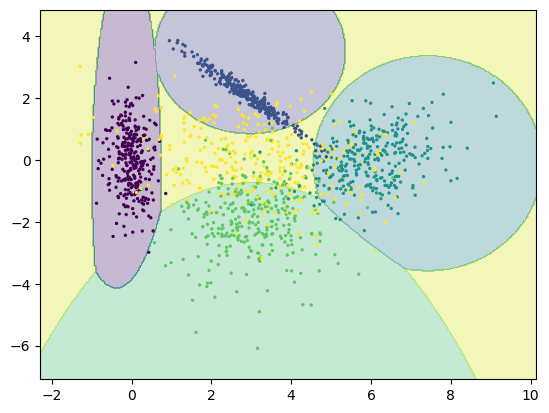

In [149]:
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(naivB, x_test, grid_resolution=400, ax=ax, alpha=.3)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='viridis', s=2, alpha=1)